## SNR to CQI 

Processed './SNR_railway_dataset/2021-05-30T14_01_49SNR.csv' and saved as './SNR_railway_dataset/UE0.csv'
Processed './SNR_railway_dataset/2021-05-30T14_01_50SNR.csv' and saved as './SNR_railway_dataset/UE1.csv'
Processed './SNR_railway_dataset/2021-05-30T14_01_51SNR.csv' and saved as './SNR_railway_dataset/UE2.csv'
Processed './SNR_railway_dataset/2021-05-30T14_03_06SNR.csv' and saved as './SNR_railway_dataset/UE3.csv'
Processed './SNR_railway_dataset/2021-05-30T14_03_08SNR.csv' and saved as './SNR_railway_dataset/UE4.csv'
Processed './SNR_railway_dataset/2021-05-30T14_04_15SNR.csv' and saved as './SNR_railway_dataset/UE5.csv'
Processed './SNR_railway_dataset/2021-05-30T14_04_17SNR.csv' and saved as './SNR_railway_dataset/UE6.csv'
Processed './SNR_railway_dataset/2021-05-30T14_05_41SNR.csv' and saved as './SNR_railway_dataset/UE7.csv'
Processed './SNR_railway_dataset/2021-05-30T14_05_42SNR.csv' and saved as './SNR_railway_dataset/UE8.csv'
Processed './SNR_railway_dataset/2021-05-30T14

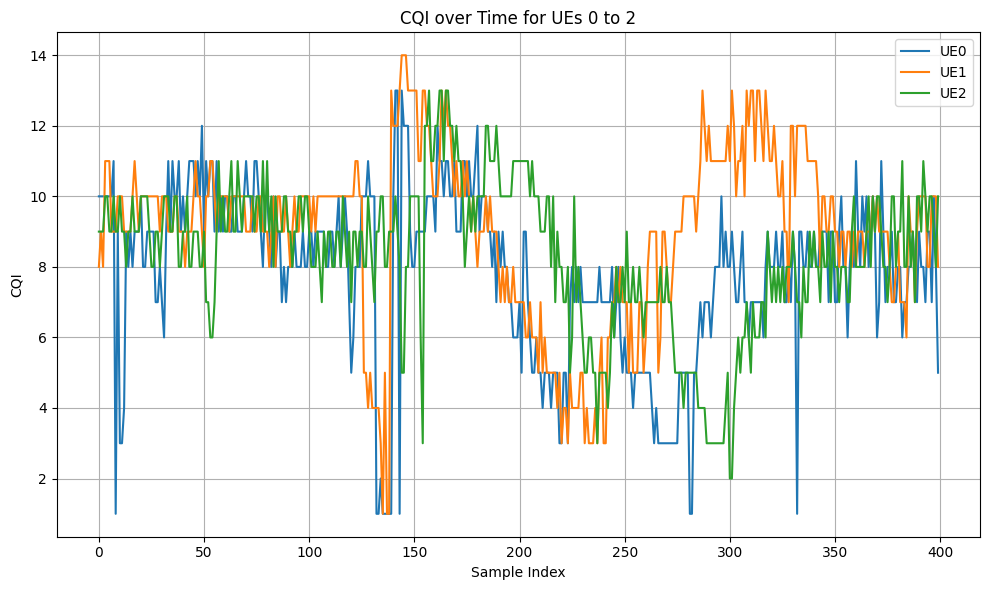

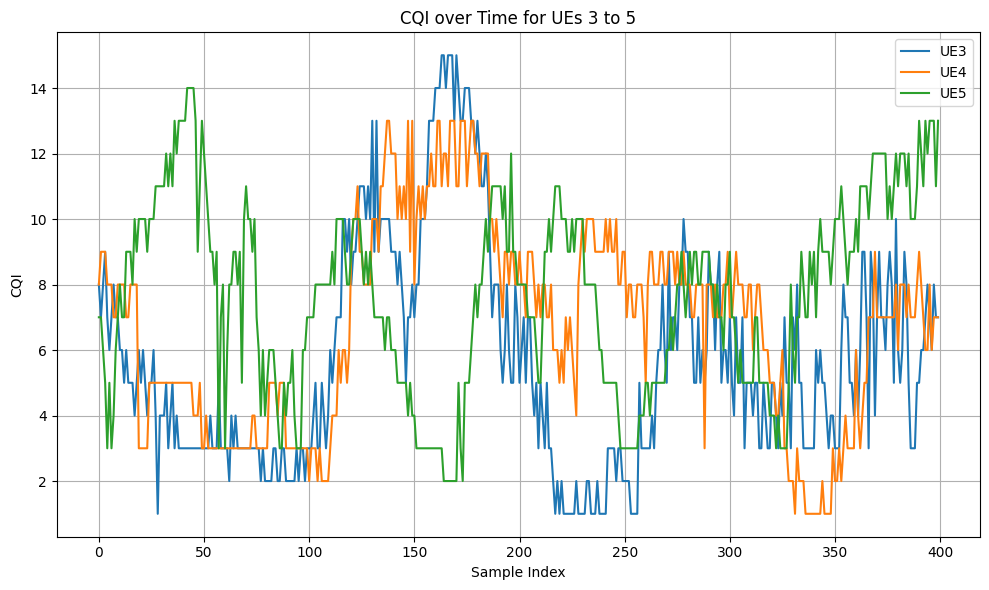

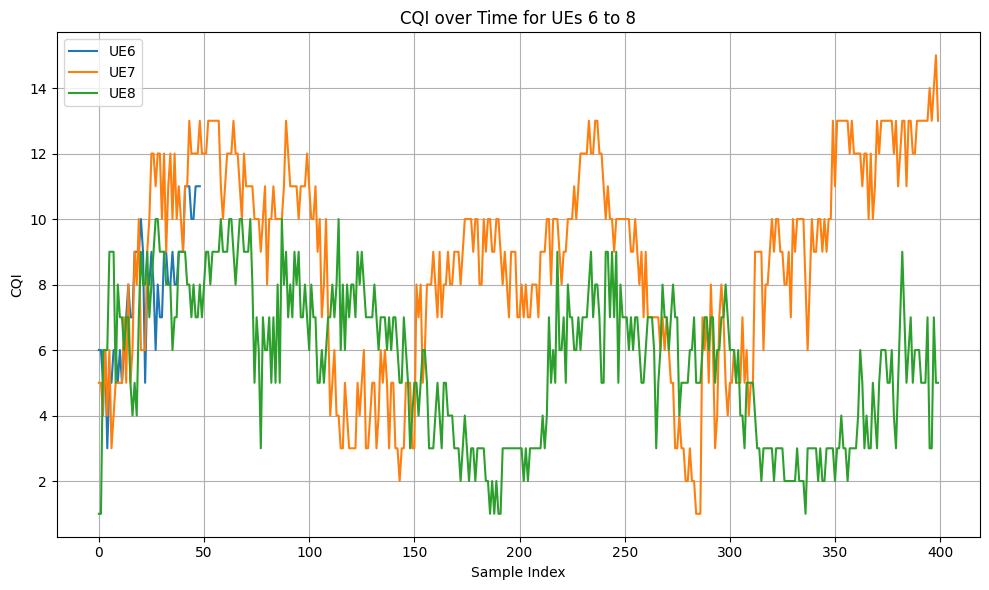

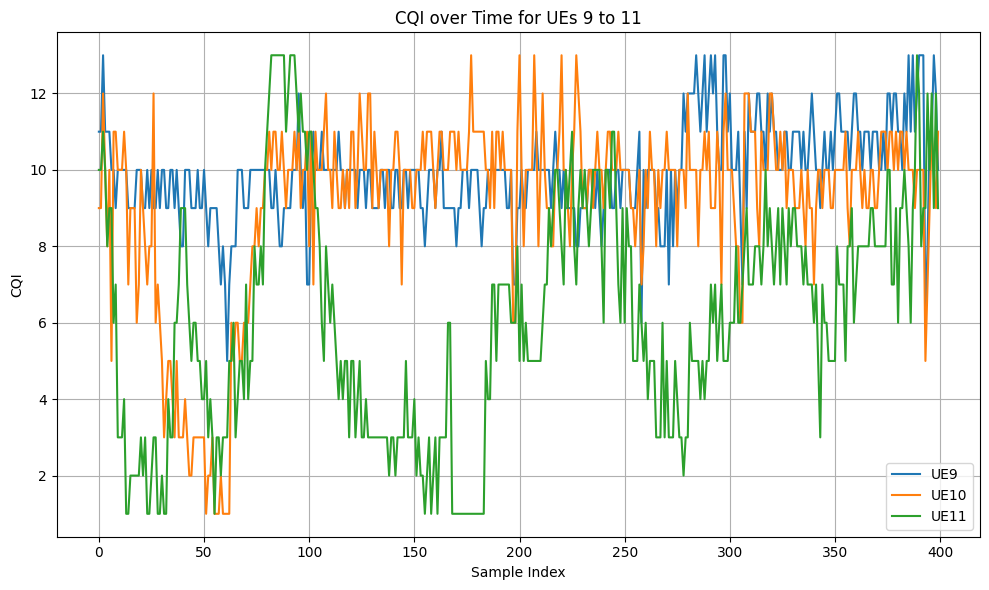

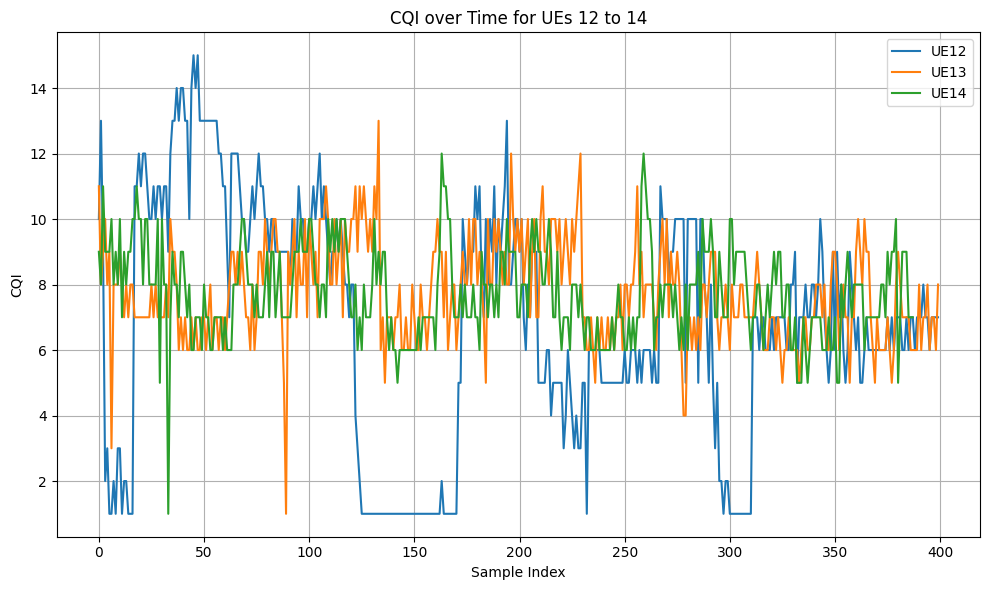

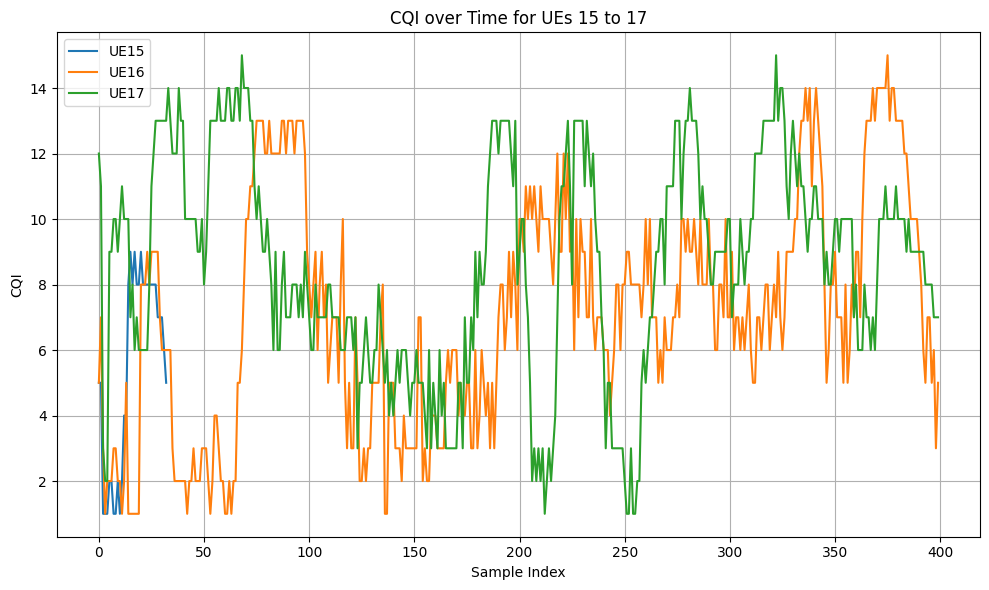

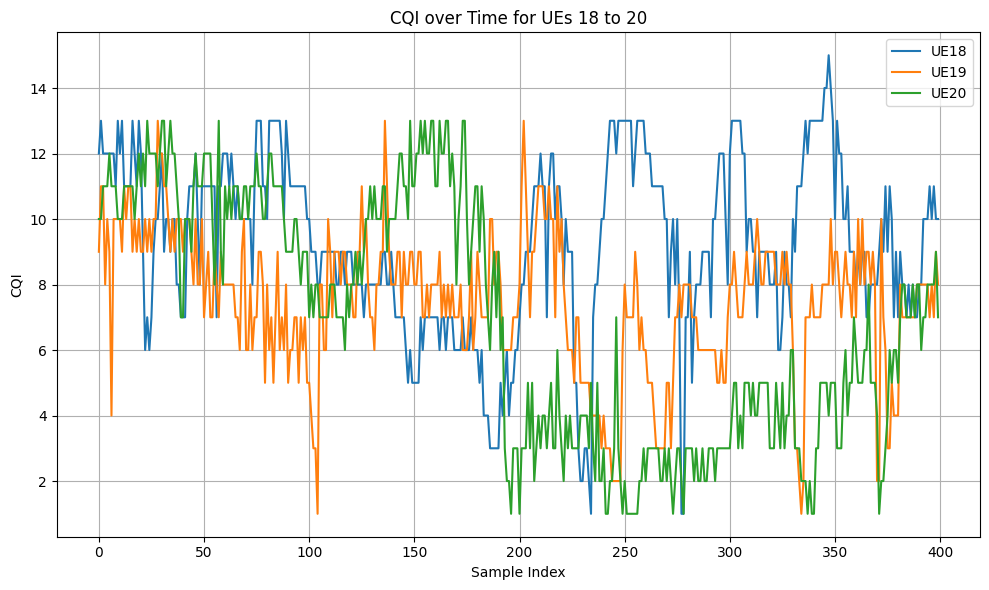

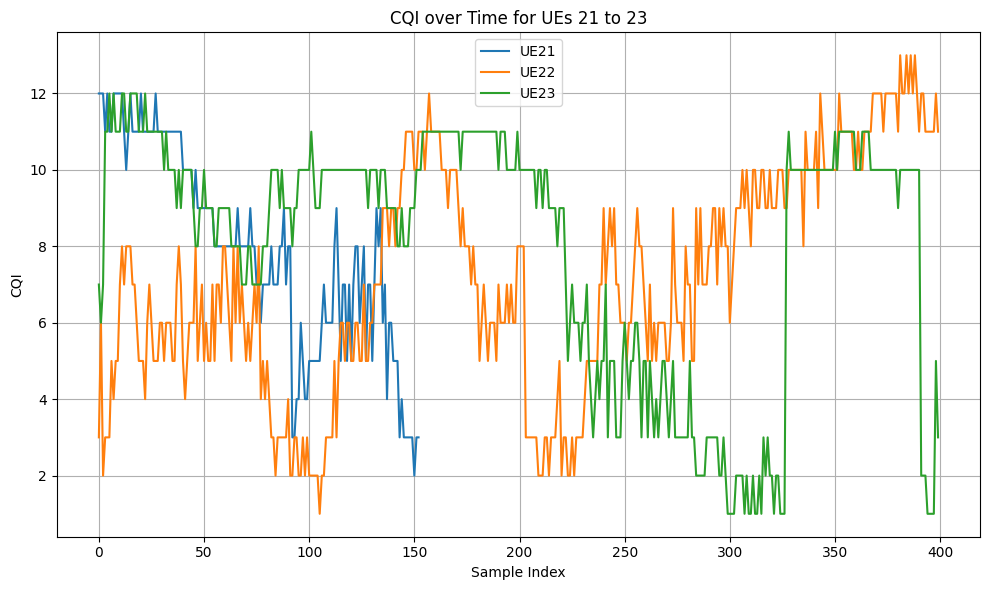

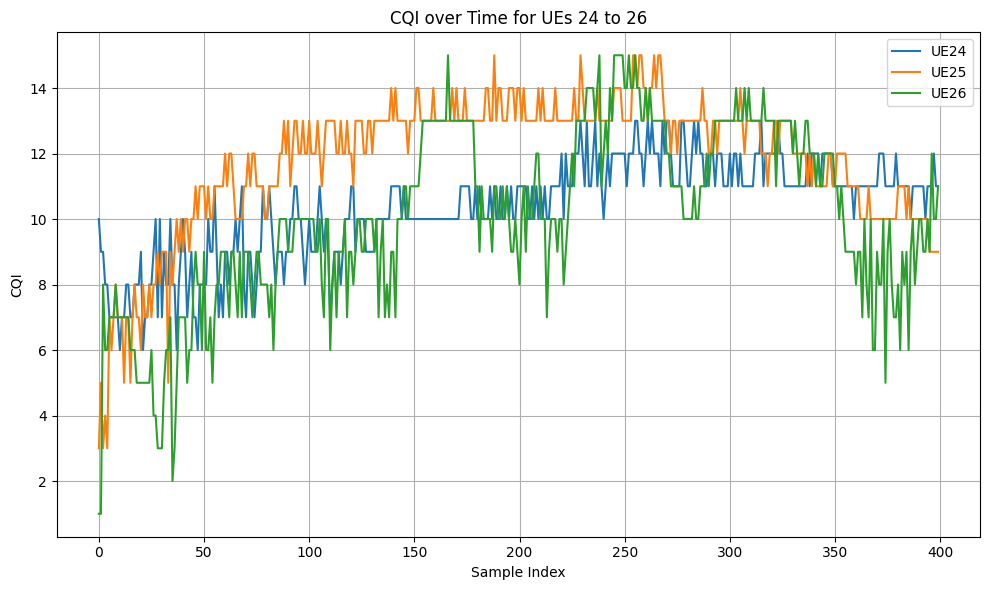

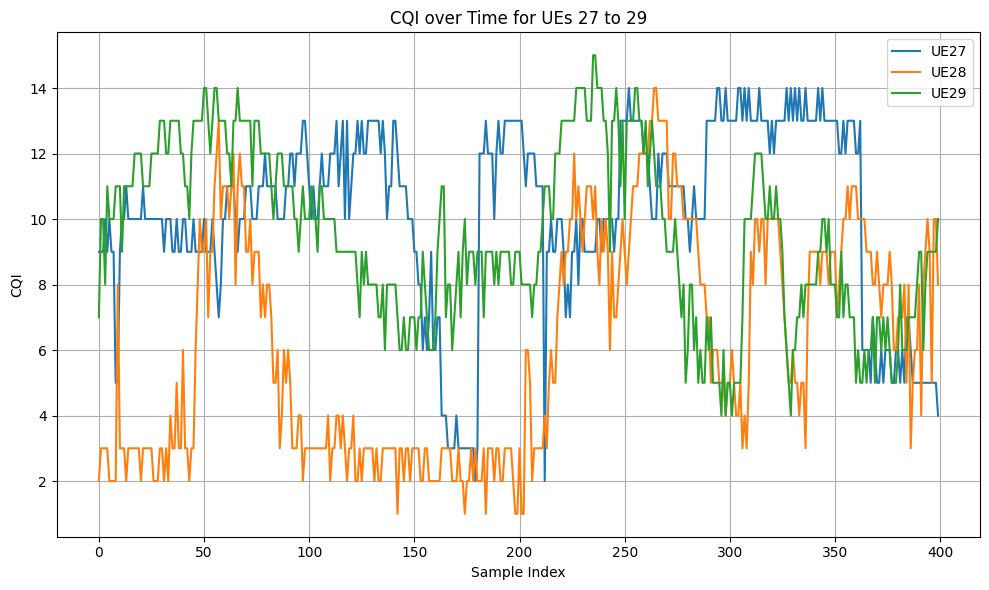

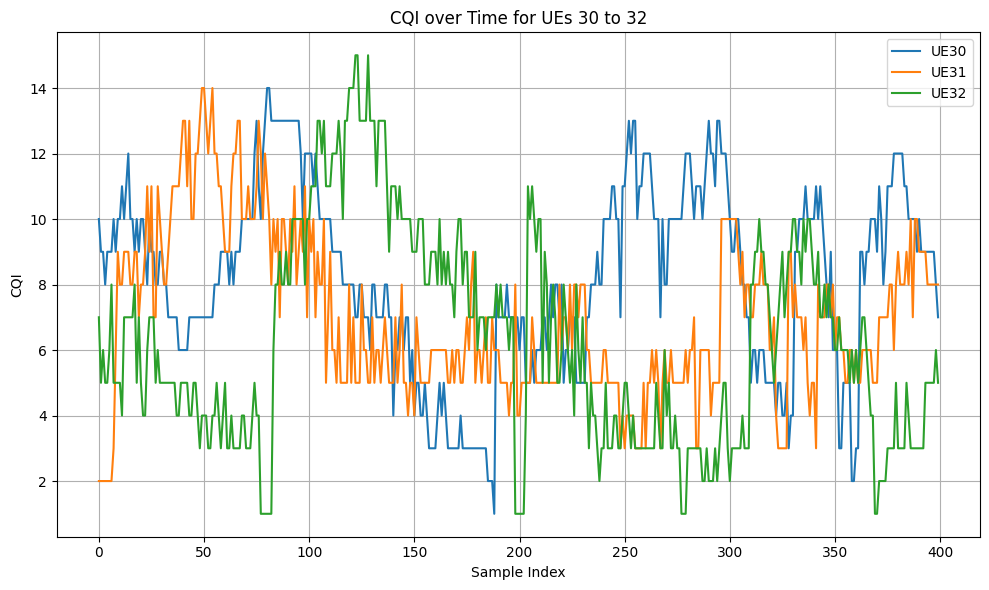

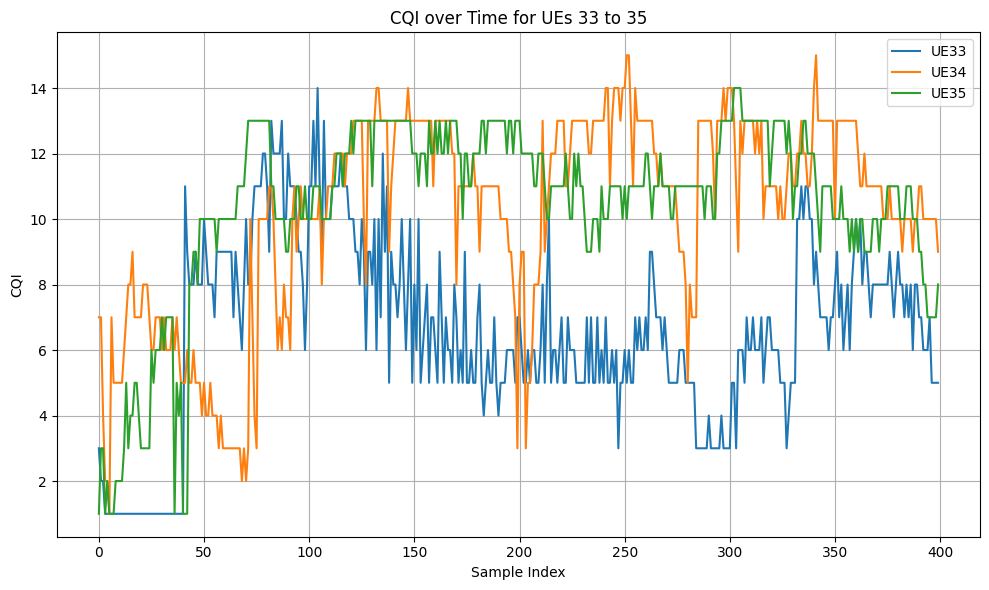

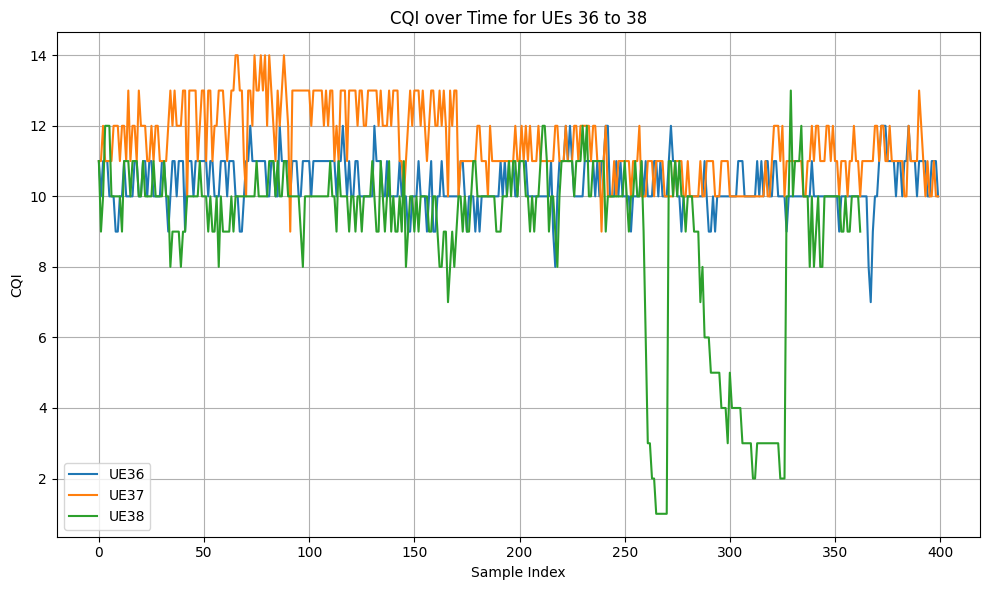

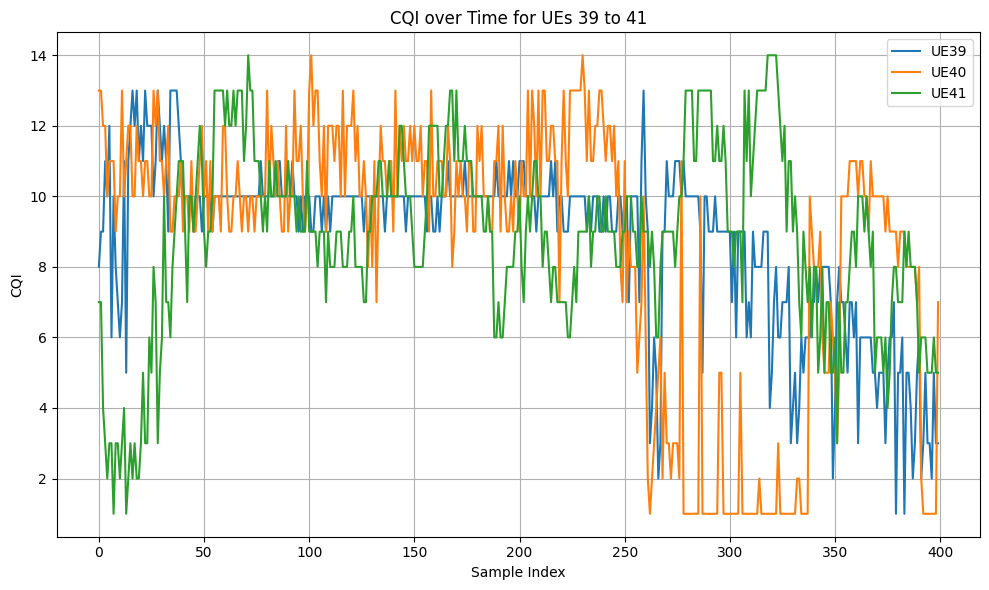

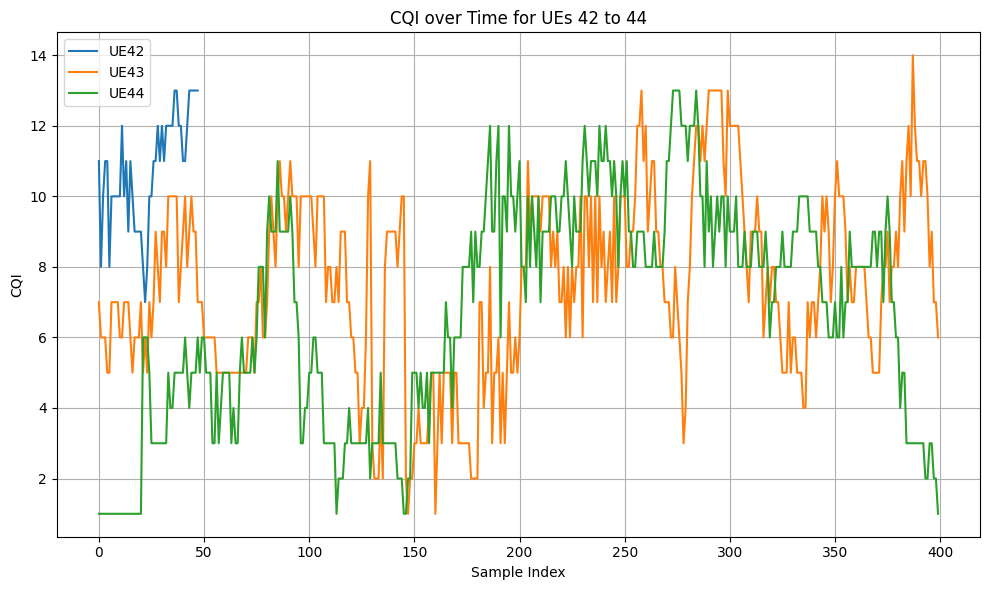

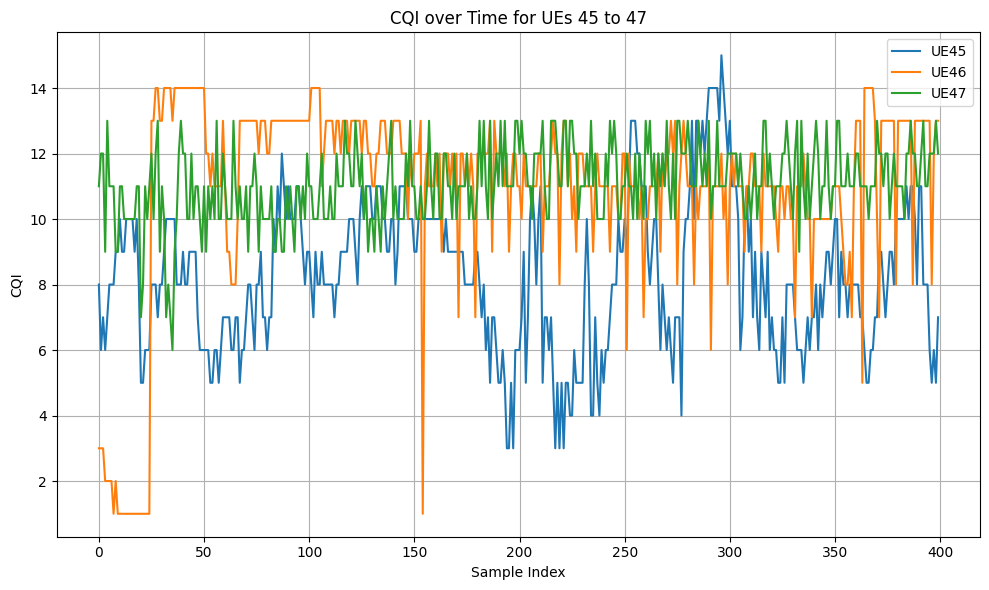

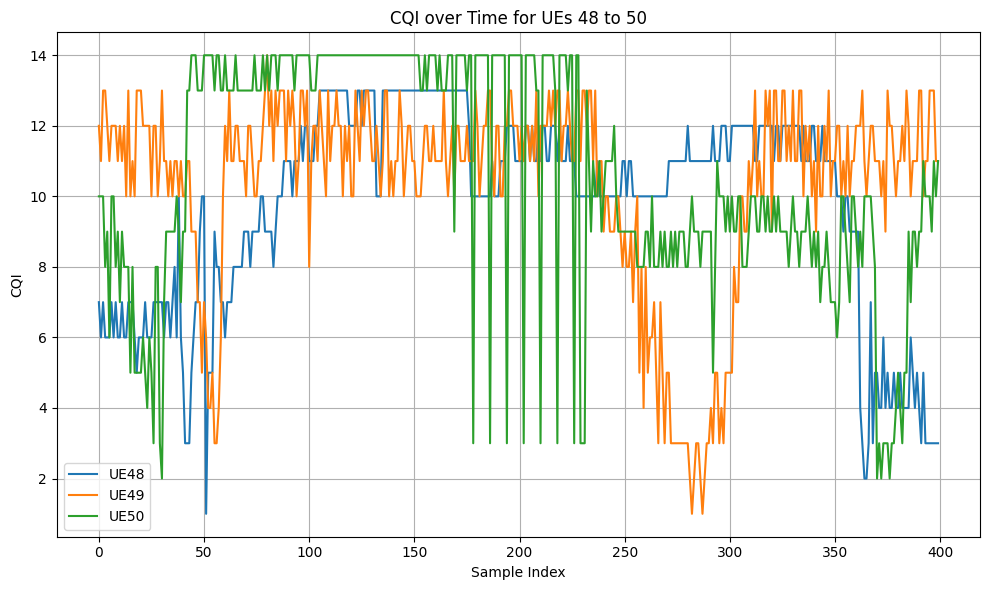

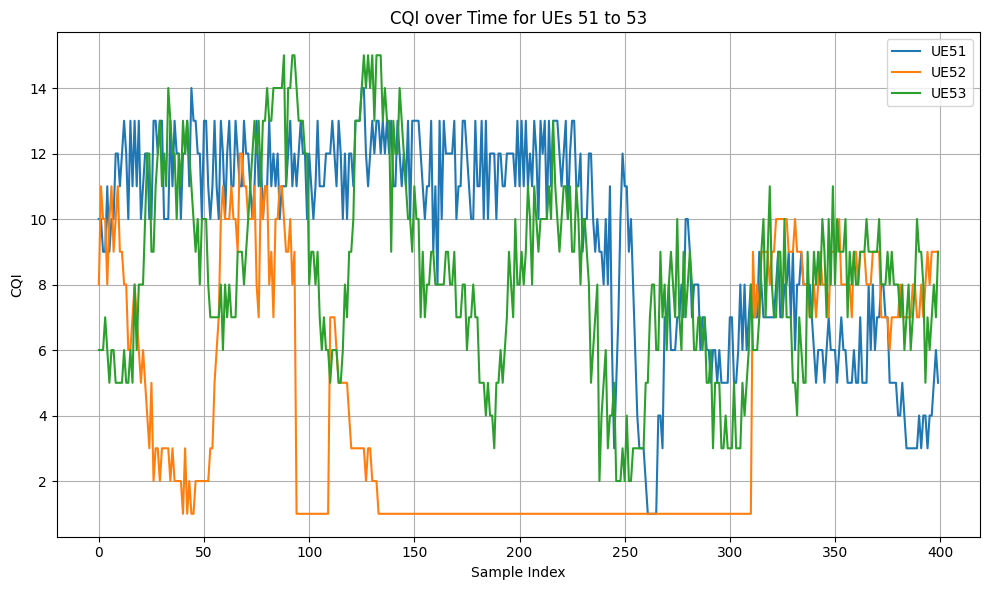

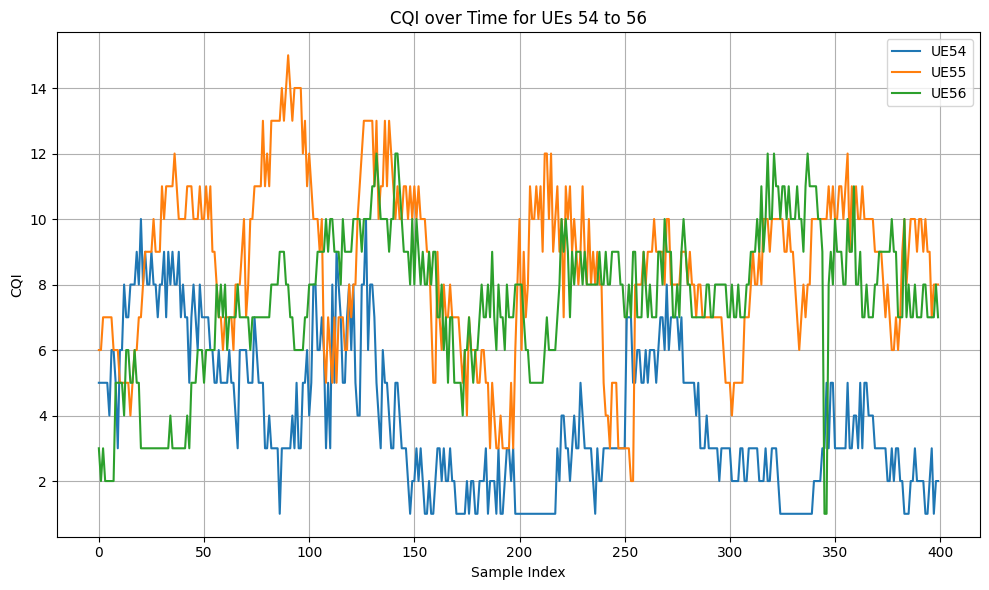

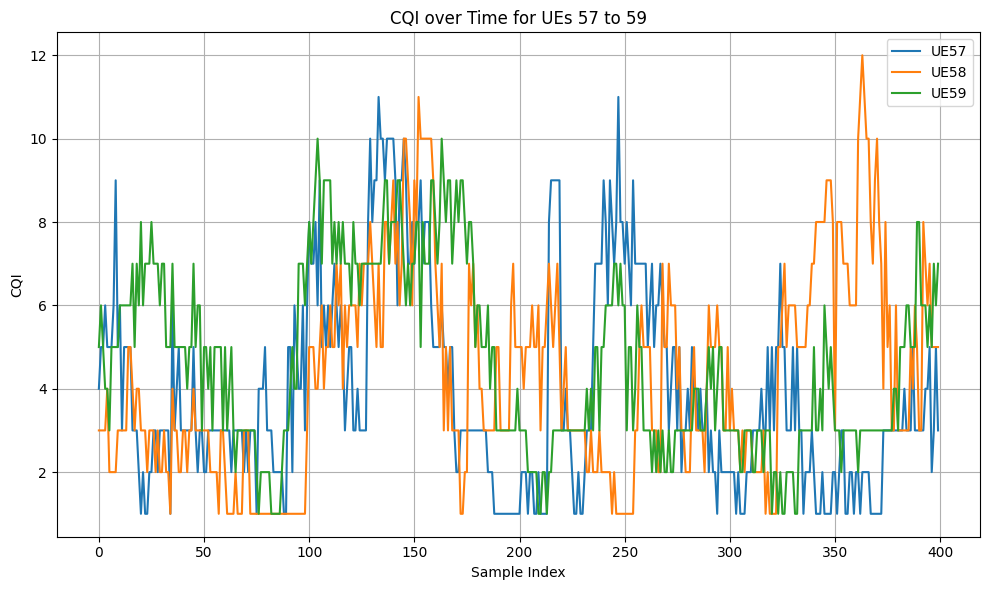

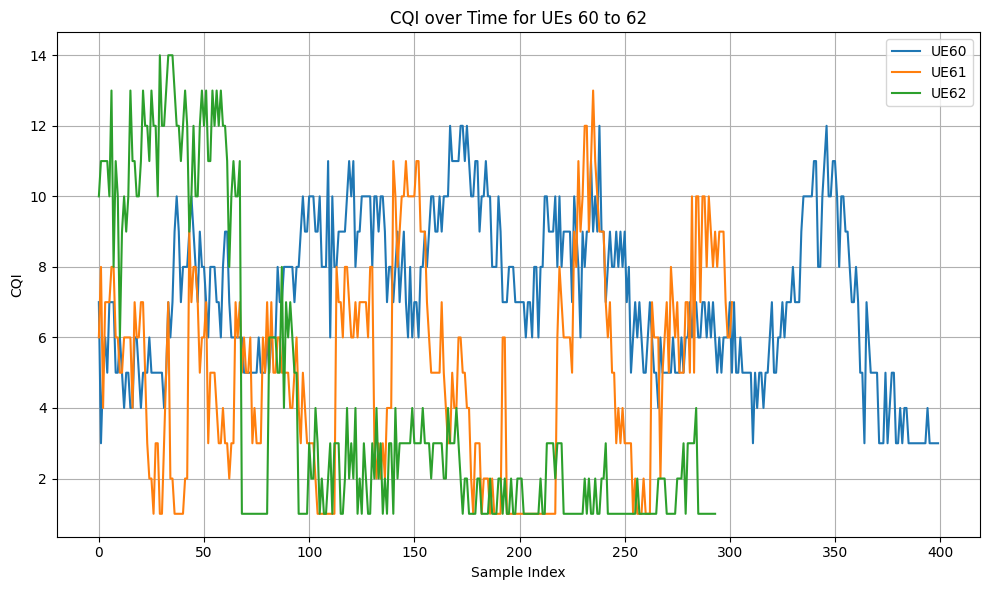

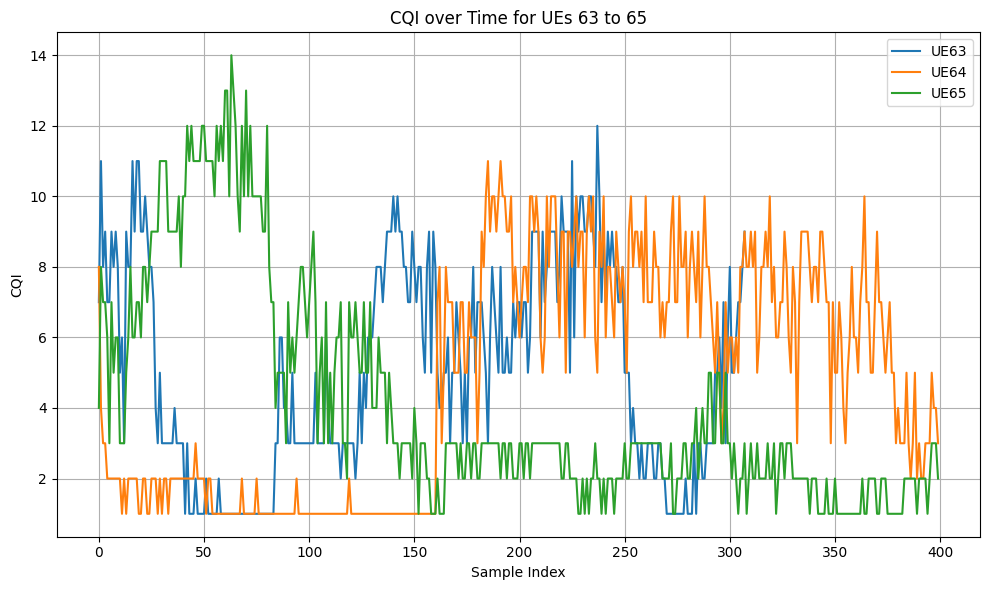

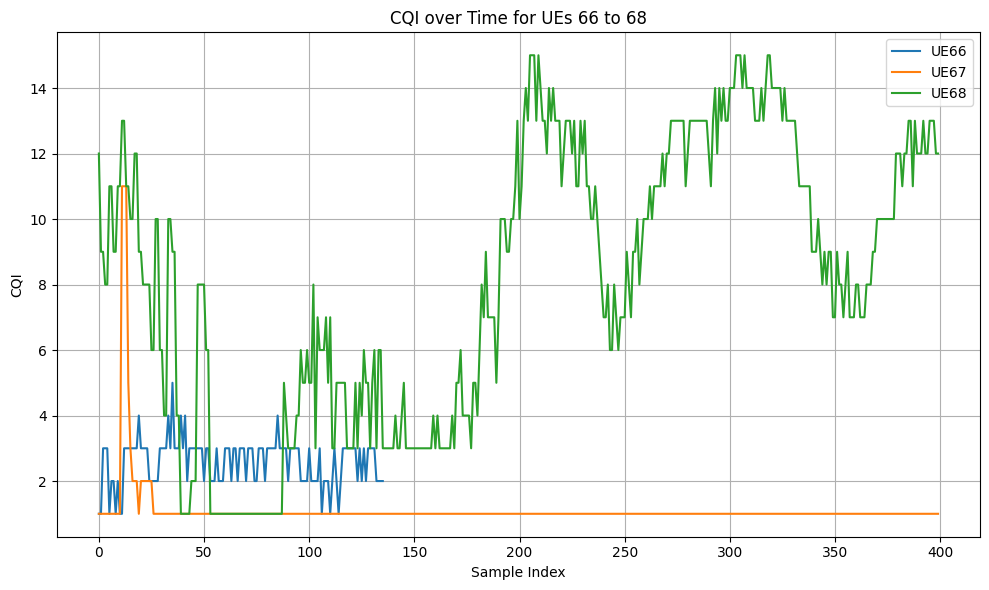

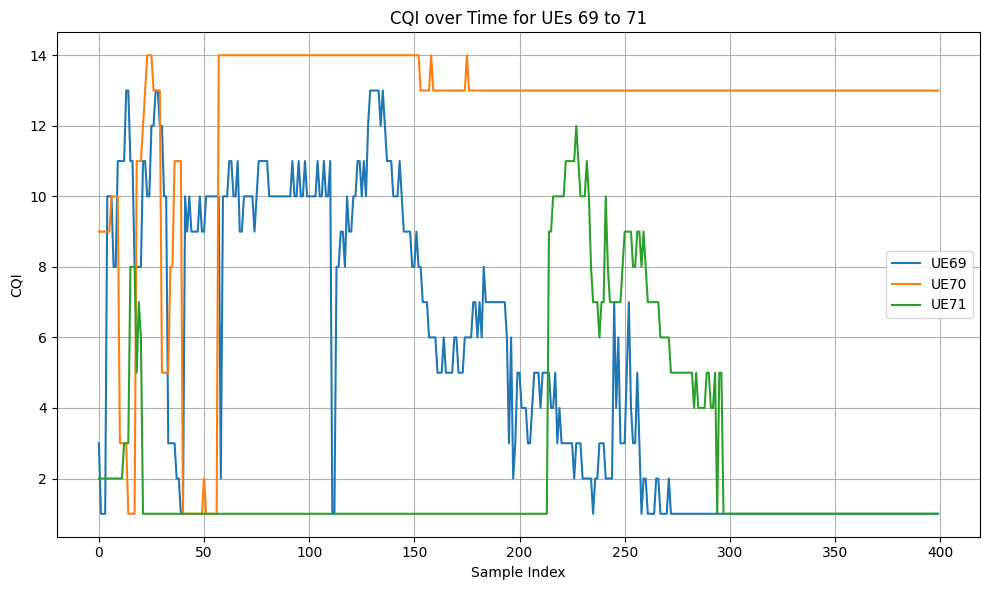

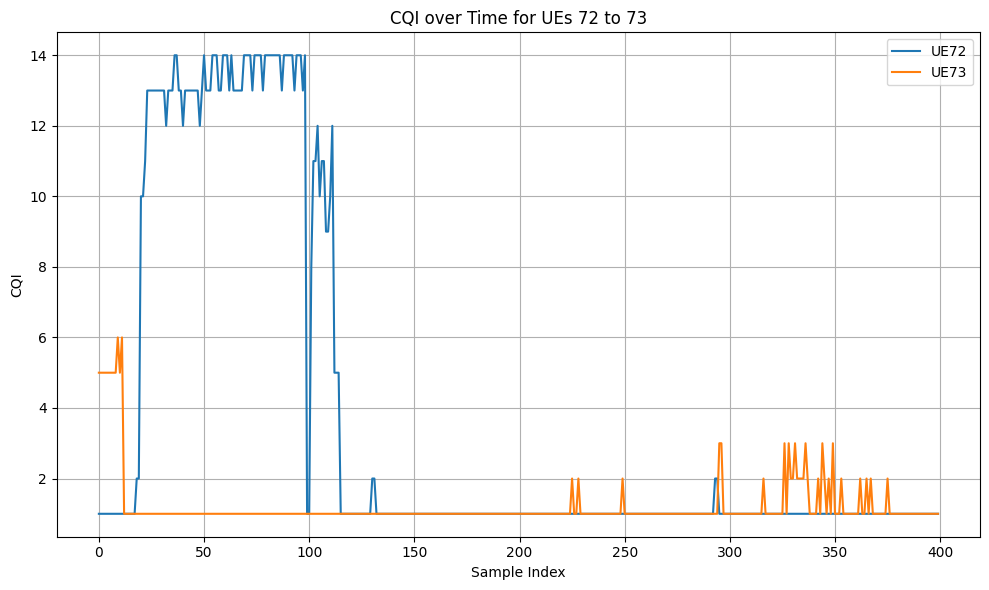

In [6]:
import os
import pandas as pd
import glob
import matplotlib.pyplot as plt
import random

folder_path = './SNR_railway_dataset/'

# Get a list of all CSV files with 'SNR' 
file_list = sorted(glob.glob(os.path.join(folder_path, '*SNR.csv')))

# Function that converts SNR to CQI based on the given thresholds.
def snr_to_cqi(snr):
    # Mapping: (threshold, CQI)
    thresholds = [
        (-6.3, 1),
        (-5.8, 2),
        (-1.4, 3),
        (3.9, 4),
        (5.3, 5),
        (8.1, 6),
        (9.8, 7),
        (11.7, 8),
        (13.6, 9),
        (15.8, 10),
        (18.8, 11),
        (21.4, 12),
        (23.6, 13),
        (28.2, 14),
        (32, 15)
    ]
    cqi = 1  # Default to the lowest CQI
    for thresh, c in thresholds:
        if snr >= thresh:
            cqi = c
        else:
            break
    return cqi


data_dict = {}

# Process each file in the list
for idx, file in enumerate(file_list):

    df = pd.read_csv(file)
    
    # Apply the SNR-to-CQI conversion on the 'SNR' column
    df['CQI'] = df['SNR'].apply(snr_to_cqi)
    df = df[['CQI']]
    
    # Save the transformed data to a new CSV file 
    output_file = folder_path + f'UE{idx}.csv'
    df.to_csv(output_file, index=False)
    
    print(f"Processed '{file}' and saved as '{output_file}'")
    
    
    data_dict[f'UE{idx}'] = df


group_size = 3
num_ues = len(data_dict)

for group_start in range(0, num_ues, group_size):
    plt.figure(figsize=(10, 6))
    # Plot each UE in the current group
    for ue in range(group_start, min(group_start + group_size, num_ues)):
        df = data_dict[f'UE{ue}']
        df_slice = df.iloc[:400]
        plt.plot(df_slice.index, df_slice['CQI'], label=f'UE{ue}')
    
    plt.xlabel("Sample Index")
    plt.ylabel("CQI")
    plt.title(f"CQI over Time for UEs {group_start} to {min(group_start + group_size - 1, num_ues - 1)}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


## subband CQI

In [ ]:


ue_files = sorted(glob.glob('./SNR_railway_dataset/UE*.csv'), key=lambda x: int(''.join(filter(str.isdigit, x))))


output_folder = './subband_cqi/'
os.makedirs(output_folder, exist_ok=True)

def generate_rgb_values(cqi):
    """
    Take the wideband CQI to convert in subband CQI. 
    Generate 7 RGB integers such that:
      - Their average is exactly the given wide band CQI 
      - Each value is in [max(1, cqi-3), min(15, cqi+3)]
    """
    L = max(1, cqi - 3)
    U = min(15, cqi + 3)
    target = 7 * cqi
    
    # If the range has no variability
    if L == U:
        return [cqi] * 7

    # Try up to 1000 attempts to randomly generate 6 numbers and compute the 7th.
    for attempt in range(1000):
        values = [random.randint(L, U) for _ in range(6)]
        current_sum = sum(values)
        r7 = target - current_sum
        if L <= r7 <= U:
            all_values = values + [r7]
            random.shuffle(all_values)  
            return all_values
    # Fallback if no valid combination is found
    return [cqi] * 7

for file in ue_files:

    df = pd.read_csv(file)
    output_df = pd.DataFrame()
    
    # Prepare lists for each RGB column (total 7 columns)
    rgb_cols = [[] for _ in range(7)]
    
    # For every row in UE file (each wideband CQI value), generate 7 RGB subband CQI numbers whose average equals the Wideband CQI.
    for x in df['CQI']:
        rgb_values = generate_rgb_values(x)
        for i in range(7):
            rgb_cols[i].append(rgb_values[i])
    
    # Assign the generated lists to the output DataFrame 
    for i in range(7):
        output_df[f'RGB{i}'] = rgb_cols[i]
    
    # Construct the output filename 
    base_name = os.path.basename(file) 
    output_filename = os.path.join(output_folder, base_name.replace("UE", "Subband_UE"))
    output_df.to_csv(output_filename, index=False)
    print(f"Processed file {file} and saved output to {output_filename}")


Processed file ./SNR_railway_dataset/UE0.csv and saved output to ./subband_cqi/Subband_UE0.csv
Processed file ./SNR_railway_dataset/UE1.csv and saved output to ./subband_cqi/Subband_UE1.csv
Processed file ./SNR_railway_dataset/UE2.csv and saved output to ./subband_cqi/Subband_UE2.csv
Processed file ./SNR_railway_dataset/UE3.csv and saved output to ./subband_cqi/Subband_UE3.csv
Processed file ./SNR_railway_dataset/UE4.csv and saved output to ./subband_cqi/Subband_UE4.csv
Processed file ./SNR_railway_dataset/UE5.csv and saved output to ./subband_cqi/Subband_UE5.csv
Processed file ./SNR_railway_dataset/UE6.csv and saved output to ./subband_cqi/Subband_UE6.csv
Processed file ./SNR_railway_dataset/UE7.csv and saved output to ./subband_cqi/Subband_UE7.csv
Processed file ./SNR_railway_dataset/UE8.csv and saved output to ./subband_cqi/Subband_UE8.csv
Processed file ./SNR_railway_dataset/UE9.csv and saved output to ./subband_cqi/Subband_UE9.csv
Processed file ./SNR_railway_dataset/UE10.csv and 